In [1]:
import argparse
import sys

import mlflow
import numpy as np
import squidpy as sq

from autotalker.analysis import plot_labeled_latent_adata
from autotalker.data import load_spatial_adata_from_csv
from autotalker.models import Autotalker

In [2]:
dataset = "squidpy_seqfish"
n_epochs = 1
lr = 0.01
batch_size = 128
n_hidden = 32
n_latent = 16
dropout_rate = 0.

In [3]:
print(f"Using dataset {dataset}.")
if dataset == "deeplinc_seqfish":
    adata = load_spatial_adata_from_csv("datasets/seqFISH/counts.csv",
                                        "datasets/seqFISH/adj.csv")
    cell_type_key = None
elif dataset == "squidpy_seqfish":
    adata = sq.datasets.seqfish()
    sq.gr.spatial_neighbors(adata, radius = 0.04, coord_type="generic")
    cell_type_key = "celltype_mapped_refined"
elif dataset == "squidpy_slideseqv2":
    adata = sq.datasets.slideseqv2()
    sq.gr.spatial_neighbors(adata, radius = 30.0, coord_type="generic")
    cell_type_key = "celltype_mapped_refined"

Using dataset squidpy_seqfish.


In [4]:
print(f"Number of nodes: {adata.X.shape[0]}")
print(f"Number of node features: {adata.X.shape[1]}")
avg_edges_per_node = round(
    adata.obsp['spatial_connectivities'].toarray().sum(axis=0).mean(),2)
print(f"Average number of edges per node: {avg_edges_per_node}")
n_edges = int(np.triu(adata.obsp['spatial_connectivities'].toarray()).sum())
print(f"Number of edges: {n_edges}", sep="")

Number of nodes: 19416
Number of node features: 351
Average number of edges per node: 4.4
Number of edges: 42694


 |████████████████████| 100.0%  - train_losses: 113737.8386467265 - valid_losses: 0.5509328024 - valid_auroc_scores: 0.8699455082 - valid_auprc_scores: 0.8426597535 - valid_best_acc_scores: 0.8092218677 - valid_best_f1_scores: 0.8342128017
Saving best state of the network...
Best state was in epoch 0
Model training finished...


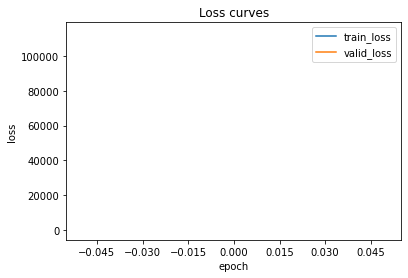

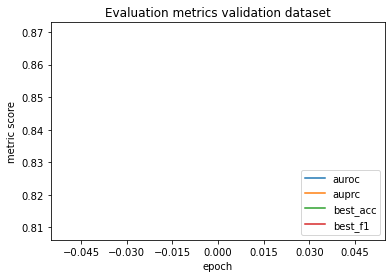

In [5]:
model = Autotalker(adata,
                   cell_type_key=cell_type_key,
                   n_hidden=n_hidden,
                   n_latent=n_latent,
                   dropout_rate=dropout_rate)

model.train(n_epochs=n_epochs,
            lr=lr,
            batch_size=batch_size)

mlflow.log_param("dataset", dataset)

model.save(dir_path="./model_artefacts",
           overwrite=True,
           save_adata=True,
           adata_file_name="adata.h5ad")

In [ ]:
model = Autotalker.load(dir_path="./model_artefacts",
                        adata=None,
                        adata_file_name="adata.h5ad",
                        use_cuda=True)

In [7]:
labeled_latent_adata = model.get_labeled_latent_adata()

/home/cartalop/sebastianbirk/autotalker/autotalker/models/_vgaemodelmixin.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(dataset.x, device=device)
/home/cartalop/sebastianbirk/autotalker/autotalker/models/_vgaemodelmixin.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(dataset.edge_index, device=device)


In [8]:
labeled_latent_adata.obs["cell_type"]

0                           Low quality
1                Lateral plate mesoderm
2                             Erythroid
3                Lateral plate mesoderm
4                             Erythroid
                      ...              
19411                       Spinal cord
19412                       Endothelium
19413                       Spinal cord
19414    Haematoendothelial progenitors
19415                       Spinal cord
Name: cell_type, Length: 19416, dtype: category
Categories (22, object): ['Allantois', 'Anterior somitic tissues', 'Cardiomyocytes', 'Cranial mesoderm', ..., 'Sclerotome', 'Spinal cord', 'Splanchnic mesoderm', 'Surface ectoderm']

cell_type
AnnData object with n_obs × n_vars = 19416 × 16
    obs: 'cell_type'
    uns: 'neighbors', 'umap'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'


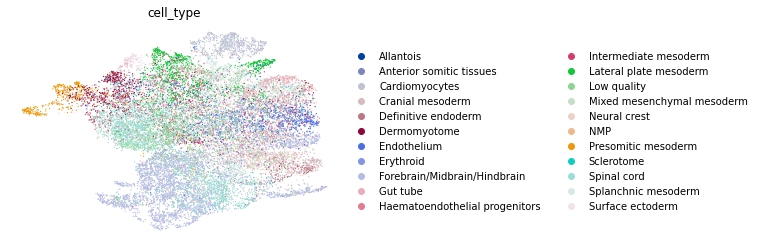

In [9]:
plot_labeled_latent_adata(labeled_latent_adata,
                          save=False)